# A Tutorial on Adversarial Robustness

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mythrandire/adversarial_tutorial/Adversarial_Tutorial.ipynb)


Turns out machine learning isn't infallible. Even with 'human-level' accuracy in tasks like classification, they are prone to relatively simple adversarial attacks. 

The key takeaway from this notebook should be this - the assertion that these algorithms have surpassed human level performance is erroneous. 

## Dependencies

To run this notebook, you need:
1. `Python 3.x`
2. `numpy`
3. `PIL`, also known as Pillow
4. `PyTorch`
5. `matplotplib`



In [1]:
#!pip3 install numpy matplotlib Pillow torch torchvision

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json

# You need PyTorch installed for this notebook
import torch
from torchvision import transforms
import torch.nn as nn
from torchvision.models import resnet50
import torch.optim as optim

## Creating Adversarial Examples

Let's invoke a pretrained ResNet50 model from PyTorch to classify a picture. Then we can proceed further.

### Read an image

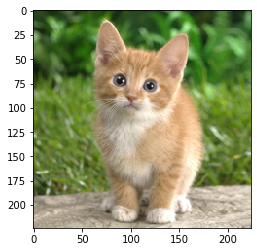

In [3]:
#read the image, resize to 224 and convert to PyTorch Tensor

cat_img = Image.open("./cat.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
cat_tensor = preprocess(cat_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(cat_tensor[0].numpy().transpose(1,2,0))

### Load pretrained model

In [4]:
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [5]:
# form predictions
pred = model(norm(cat_tensor))

The variable `pred` now contains a 1000 dimensional vector containing the class logits for the 1000 imagenet classes. To find the highest likelihood class, we take the index of maximum value in the vector and find the corresponding label.

In [6]:
with open("./imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

tabby


### Fooling the classifier

This is what you came for, after all. 

But first, some math.

#### Notations and Theory

Let us define the model (which should more appropriately be called the hypothesis):
$$
h_{\theta} : \chi \longrightarrow \mathbb{R}^k
$$
$k$ is the number of classes, $\theta$ are the parameters defining the model. 

Next, we define the loss function:

$$
l : \mathbb{R}^k \times \mathbb{Z}_{+} \longrightarrow \mathbb{R}_{+}
$$

which is a mapping from the predictions and true labels to a non-negative number. From this we can arrive at the common notation $l(h_\theta (x), y)$ for $x \in \chi$ in the input and with $y \in \mathbb{Z}$ being the true class. 

#### Cross Entropy Loss

The most commonly used loss function in classification tasks. 

$$
l(h_\theta (x), y) = log \left( \sum_{j=1}^{k} exp(h_\theta(x)_j) \right) - h_\theta(x)_y
$$

The goal of training a network is to maximize the probability of the true class label. Since probabilities can be vanishingly small, it is sensible to **maximize the log of the probability of the true class label.**

In [7]:
print(nn.CrossEntropyLoss()(model(norm(cat_tensor)),torch.LongTensor([281])).item())

1.2442411184310913


### Creating an Adversarial Example

In [8]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(cat_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(cat_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([281]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,281].item())

0 -1.2442411184310913
5 -20.247913360595703
10 -21.87263298034668
15 -24.33418846130371
20 -24.000591278076172
25 -23.429275512695312
True class probability: 5.71168876084549e-11


So after 30 gradient steps, this classifier thinks this image has less than a $10^{-11}$ chance of being a tabby. 

Let's see what it's been fooled into classifying the cat as.

In [9]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  red_fox
Predicted probability: 0.9889766573905945


What happened to the original image that the classifier thinks its a red fox? We can verify this by checking the modified image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


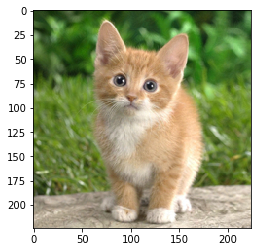

In [10]:
plt.imshow((cat_tensor + delta)[0].detach().numpy().transpose(1,2,0))

It looks the same! What does the `delta` we added to the image look like?


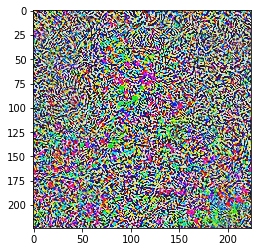

In [11]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

### Why is this happening?

The common approach to training a classifier is to optimize the parameters $\theta$, so as to minimize the average loss over some training set. Typically this is solved through some form of gradient descent. 

Without listing all the mathematical formulation, we can get straight to the point. 

The quantity of interest when computing the gradient update steps is the gradient of loss $\nabla l(h_\theta(x_i), y_i)$. This term computes the extent some adjustment made to the parameters $\theta$ will affect the loss function. 

For our nefarious purposes (purely academic in scope), we can just as easily compute the gradient of the loss with respect to the input $x_i$ - which will allow us to compute the `delta` change needed to fool the classifier. 

Instead of adjusting the image to minimize the loss, we just want to adjust the image to **maximize** the loss. Mathematically, this means:
$$
\max_{\hat{x}} l(h_\theta(\hat{x}), y)
$$

where $\hat{x}$ is the intended **adversarial example**. 

### Targeted Attacks

What if, as budding ML villains, we want the classifier to not just misclassify the cat, but actually classify it as belonging to a class of our choosing? Fortunately for us, adversarial attacks are not restricted to stochastic acts of nerdy terrorism. 

Mathematically, the optimization problem we're trying to solve increases in complexity by some margin. The technique we used previously can also be used to classify the image as any class we choose. This is known as a **targeted attack**.

Instead of trying to simply maximize the loss of the correct class, we now maximize the loss of the correct class while minimizing the loss of the target class.

In [12]:
delta = torch.zeros_like(cat_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(cat_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([281])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([637])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 9.3342924118042
10 -4.04715633392334
20 -10.203152656555176
30 -15.19017505645752
40 -19.859649658203125
50 -23.3283634185791
60 -27.185640335083008
70 -29.293190002441406
80 -31.36945343017578
90 -33.13526153564453


In [13]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  mailbox
Predicted probability: 0.9999997615814209


**A mailbox?** But it was a cat? Looks like Schrodinger was right!

Again, just as a sanity check, we verify that the cat looks just the same as it originally did. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


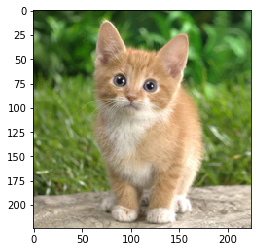

In [14]:
plt.imshow((cat_tensor + delta)[0].detach().numpy().transpose(1,2,0))

Let's take a look at the noise that put the cat in a box:

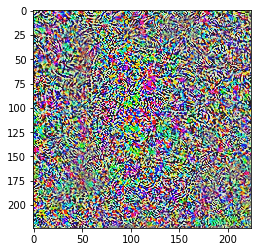

In [15]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

### Human-level Performance?

Clearly, it is laughable to assert that these models are performing at near-human levels. This seemingly superhuman performance comes from **learning and also predicting on data that is generated from the same sampling conditions**. This is why real world performance of most home-grown classifiers is not going to be great, no matter how great your test and validation results are. 

## Adversarial Attacks

Okay, so you've had enough of being the villain and now want to find out how to ensure your own classifier can withstand adversarial attacks, be they random, targeted, white-box or black-box attacks. 

Mathematically, you could write the impending optimization problem as ... a very complicated term. Before we get there, we need to arrive at a necessary concept. 

The first step toward creating a strategy for adversarial training is to understand risk and how adversarial examples can be generated in a non-naive way. 


### The concept of Risk



#### Risk for classifiers
The concept of risk is not unfamiliar in machine learning. The risk of a classifier is it’s expected loss under the true distribution of samples.

$$
R(h_{\theta}) = \mathbb{E}_{(x,y) \sim \mathcal{D}} [l(h_\theta(x), y)]
$$

where $\mathcal{D}$ is the true distribution over all samples. Practically this distribution is never known, so it must be approximated over a set of finite samples:
$$
D = \{ (x_i, y_i) \sim \mathcal{D} \}, i=1, ..., m
$$

Thus, empirically the risk can be written as

$$
\hat{R}(h_\theta, D) = \frac{1}{|D|} \sum_{(x,y) \in D} l(h_\theta(x), y)
$$

Keeping with these notations, the task of training is simply finding the parameters which minimize this risk on a training set $D_{train}$. 

$$
\min_{\theta} \hat{R}(h_\theta, D_{train})
$$

#### Adversarial Risk

Similarly, the case where the worst case loss occurs in some region around the sample give us **adversarial risk**:

$$
R_{adv}(h_\theta) = \mathbb{E}_{(x,y) \sim \mathcal{D}} \left[ \max_{\delta \in \Delta(x)} l(h_\theta(x+\delta), y)\right]
$$

$\Delta(x)$ is the region of valid perturbations. Again, there is a corresponding empirical adversarial risk, since the true distribution $\mathcal{D}$ is unknown. Thus, we get the following expression for adversarial risk:

$$
\hat{R}_{adv}(h_\theta, D) = \frac{1}{|D|} \sum_{(x,y) \in D} \max_{\delta \in \Delta(x)} l(h_\theta(x + \delta), y)
$$

With these considerations in mind, we are finally in a position to tackle the task of training classifiers that are robust to adversarial attacks. With the mathematical formulation and understanding of adversarial risk, the task of training a robust classifier boils down to **training a classifier that minimizes empirical adversarial risk**

$$
\min_{\theta} \hat{R}_{adv}(h_\theta, D_{train})
$$

which expands to 

$$
\min_{theta} \frac{1}{|D_{train}|} \sum_{(x,y) \in D_{train}} \max_{\delta \in \Delta(x)} \left(loss \right)
$$

where `loss` is our familiar friend  $l(h_\theta(x+\delta), y)$.



Text(0, 0.5, 'Output')

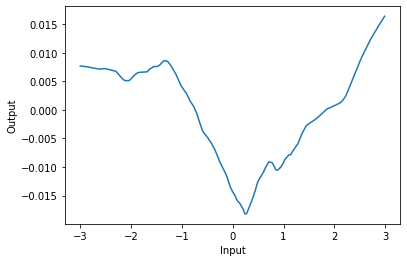

In [16]:
torch.manual_seed(0)
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()


plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

In [17]:
# Recall that a small perturbation in the input space dominos into large changes in loss. 
# This was illustrated well by the x = [1 0 1 0] ----> [0.9, -0.1, 1.1, ...] example we discussed in class

The purpose of the above visualization is to illustrate how 'bumpy' the loss for a neural network can be. This is relevant, since it presents two hurdles:

1. With high dimensional problems like these, at several points in the input space, the chance that a steep incline exists in their neighborhood is very high. **This is why neural networks are especially prone to adversarial attacks.** It is a direct consequence of the nature of the loss surface.

2. Non-convex curve - not easy to solve. 

### MNIST

To start, let's train a trio of models on MNIST. 

In [5]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

model_dnn_4 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,100), nn.ReLU(),
                            nn.Linear(100,100), nn.ReLU(),
                            nn.Linear(100,10)).to(device)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

from torchvision import datasets
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


#### DNN (model-1)

Dense layers, shallow network.

In [19]:
"""
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
"""

0.134117	0.517456	0.081000	0.287926
0.075617	0.265120	0.063900	0.221750
0.059017	0.209297	0.051500	0.182848
0.049083	0.172956	0.046900	0.157959
0.041867	0.146733	0.039800	0.136166
0.036267	0.126979	0.036200	0.123044
0.031350	0.112057	0.034400	0.115782
0.028300	0.100220	0.031600	0.106184
0.025350	0.090500	0.029900	0.099567
0.023083	0.082749	0.028600	0.093475


#### DNN (model-2)

Dense layers, slightly deeper. 

In [20]:
"""
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
"""

0.234800	0.777811	0.085400	0.274949
0.066417	0.222066	0.053200	0.169565
0.043100	0.144024	0.036400	0.119340
0.031067	0.106698	0.035800	0.113578
0.025000	0.083630	0.027900	0.089875
0.020933	0.069366	0.023900	0.077770
0.017167	0.057285	0.024700	0.074198
0.014317	0.047497	0.023000	0.072301
0.011517	0.038867	0.022500	0.075957
0.009600	0.033076	0.022200	0.073872


#### CNN (model-3)

In [21]:
"""
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

torch.save(model_cnn.state_dict(), "model_cnn.pt")
"""

0.207167	0.614750	0.025200	0.080944
0.024983	0.081403	0.018000	0.056225
0.016500	0.052890	0.017300	0.050458
0.012533	0.039652	0.014400	0.042266
0.010833	0.033212	0.013000	0.042535
0.004467	0.015981	0.011600	0.035592
0.003383	0.012585	0.011000	0.035415
0.003050	0.011049	0.011400	0.036231
0.002750	0.009932	0.011300	0.037062
0.002333	0.008983	0.011300	0.037002


If you don't have a gpu, you can save time and load the saved models.

In [22]:
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

'\nmodel_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))\nmodel_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))\nmodel_cnn.load_state_dict(torch.load("model_cnn.pt"))\n'

### Fast Gradient Sign Method

One common white-box attack is the **Fast Gradient Sign Method** (FGSM). 

$$
\DeclareMathOperator\sign{sign}
x_{adv} = x + \epsilon * \sign(\nabla l(h_\theta(x + \delta), y))
$$

In [2]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [24]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

#### DNN (model-1)

**Original Predictions**

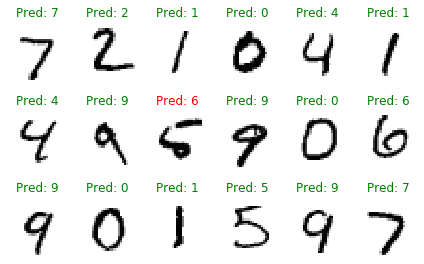

In [25]:
### Illustrate original predictions
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

**Predictions on attacked images**

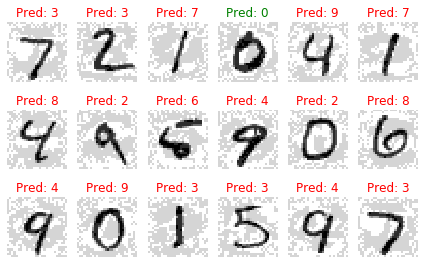

In [26]:
### Illustrate attacked images
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

#### CNN (model-3))

**Original Predictions**

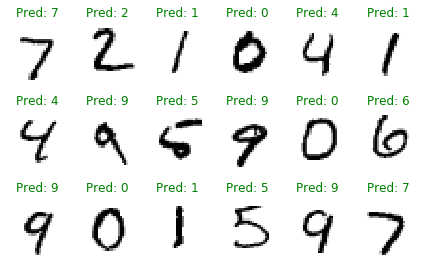

In [27]:
### Illustrate original predictions
yp = model_cnn(X)
plot_images(X, y, yp, 3, 6)

**Predictions on attacked images**

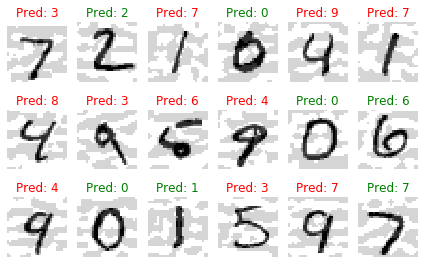

In [28]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

### Quantifying the effect of Adversarial Attacks

What are the test errors due to the FGSM attacks on the 2 layer, 4 layer DNN and the CNN?

In [29]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [30]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN: 0.9261
4-layer DNN: 0.88
        CNN: 0.409


Look again, those values aren't reporting accuracy - that's error!

Another method you can explore is projected gradient descent. 

In [3]:
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

## Adversarial Training

Straight to the point, then. If you have some input-output pairs $S$ to train a classifier robust to adversarial attacks, we want to solve the following problem:

$$
\min_{\theta} \frac{1}{|S|}\sum_{x,y \in S} \max_{||\delta|| \leq \epsilon} l(h_\theta(x + \delta), y)
$$

The simplest strategy for training an adversarially robust model is the most intuitive way out. All we have to do is create and then incorporate adversarial examples into the training process.

The strategy boils down to:
1. For a minibatch $B$, initialize gradient vector $g$. 
2. For each $(x, y)$ in the minibatch
  *   Find a perturbation $\delta^\star$ by optimizing 
      $$
      \DeclareMathOperator\sign{arg}
      \delta^\star = \arg\max_{||\delta|| \leq \epsilon} l(h_theta(x + \delta), y)
      $$
  *   Add the gradient at $\delta^\star$
      $$
      g := g + \nabla_\theta l(h_\theta(x + \delta^\star), y)
      $$
3. Update the parameters $\theta$



In [6]:
torch.manual_seed(0)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)    

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

In [7]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, epsilon=0.1, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

First, we train a simple model and evaluate adversarial error.

In [34]:
"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn.state_dict(), "model_cnn.pt")
"""

0.270633	0.034300	0.650500
0.026817	0.020400	0.677600
0.017700	0.018400	0.609400
0.012633	0.013400	0.701100
0.010300	0.014500	0.712500
0.003950	0.010800	0.695200
0.002617	0.011200	0.692100
0.002300	0.010700	0.697200
0.002150	0.010700	0.703600
0.001833	0.011000	0.699000


Clearly, the adversarial error (3rd column) is pretty bad. 

In [8]:
# load the model back if you need to
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

Now, let's try adversarial training for a more robust model. 

In [9]:
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [37]:
"""
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_err, test_loss = epoch(test_loader, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")
"""

0.579483	0.053700	0.140400
0.087050	0.022000	0.070400
0.051217	0.016000	0.045900
0.038650	0.011100	0.036000
0.030583	0.010700	0.034000
0.021750	0.008800	0.029400
0.020333	0.008600	0.029400
0.019433	0.008700	0.028700
0.018933	0.008200	0.028300
0.018267	0.008400	0.028800


In [10]:
# load the model back if you need to 
model_cnn_robust.load_state_dict(torch.load("./model_cnn_robust.pt"))

<All keys matched successfully>

### Evaluation

In [13]:
print("FGSM: ", epoch_adversarial(test_loader, model_cnn_robust, fgsm)[0])

FGSM:  0.0269


In [43]:
print("PGD, 40 iter: ", epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0])


PGD, 40 iter:  0.0291


### Interpreting performance

Let’s look at a projection of the loss function along two dimensions in the input space (one the direction of the actual gradient, and one a random direction)

In [13]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

def draw_loss(model, X, epsilon):
    Xi, Yi = np.meshgrid(np.linspace(-epsilon, epsilon,100), np.linspace(-epsilon,epsilon,100))
    
    def grad_at_delta(delta):
        delta.requires_grad_(True)
        nn.CrossEntropyLoss()(model(X+delta), y[0:1]).backward()
        return delta.grad.detach().sign().view(-1).cpu().numpy()

    dir1 = grad_at_delta(torch.zeros_like(X, requires_grad=True))
    delta2 = torch.zeros_like(X, requires_grad=True)
    delta2.data = torch.tensor(dir1).view_as(X).to(device)
    dir2 = grad_at_delta(delta2)
    np.random.seed(0)
    dir2 = np.sign(np.random.randn(dir1.shape[0]))
    
    all_deltas = torch.tensor((np.array([Xi.flatten(), Yi.flatten()]).T @ 
                              np.array([dir2, dir1])).astype(np.float32)).to(device)
    yp = model(all_deltas.view(-1,1,28,28) + X)
    Zi = nn.CrossEntropyLoss(reduction="none")(yp, y[0:1].repeat(yp.shape[0])).detach().cpu().numpy()
    Zi = Zi.reshape(*Xi.shape)
    #Zi = (Zi-Zi.min())/(Zi.max() - Zi.min())
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ls = LightSource(azdeg=0, altdeg=200)
    rgb = ls.shade(Zi, plt.cm.coolwarm)

    surf = ax.plot_surface(Xi, Yi, Zi, rstride=1, cstride=1, linewidth=0,
                       antialiased=True, facecolors=rgb)


#### Loss Surface of standard network

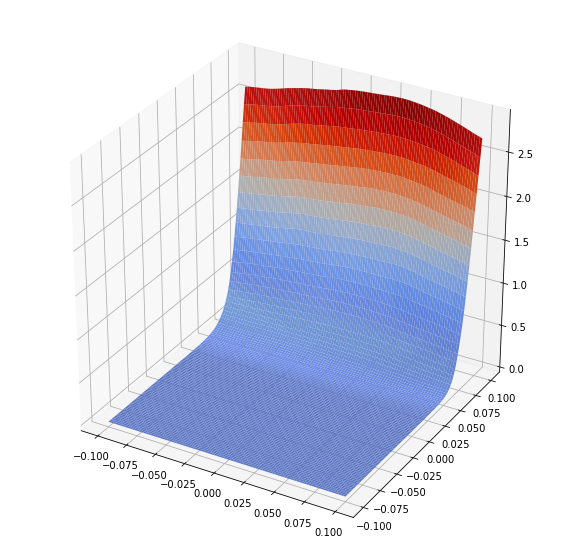

In [14]:
draw_loss(model_cnn, X[0:1], 0.1)

#### Loss Surface of robust network

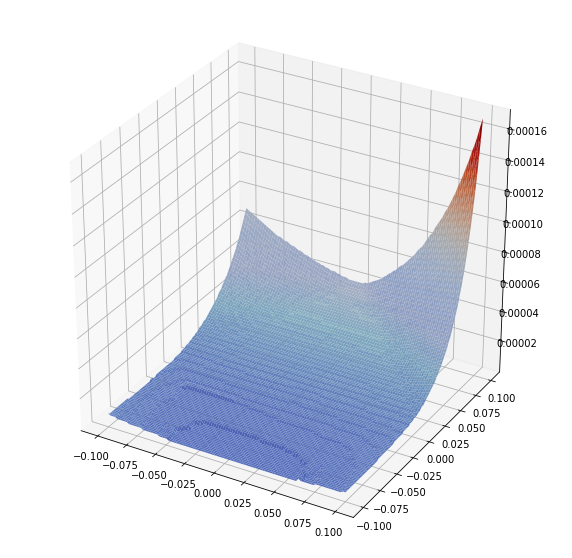

In [15]:
draw_loss(model_cnn_robust, X[0:1], 0.1)

There is a misleading bumpiness to the second surf plot. It would appear far smoother than the first plot at the same scale. Notice that the $z$ axis of both have different bounds.

Keeping the above in mind, one realizes that the robust model's loss is quite flat, both in the gradient direction (the steeper direction), and in the random direction. The traditional model on the other hand varies rapidly in both directions.

# Acknowledgement

The code in this tutorial has been compiled and condensed from the extremely comprehensive and brilliantly explained chapters on Adversarial Robustness by Zico Kolter and Aleksander Madry, which can be found [here](https://adversarial-ml-tutorial.org/).

This tutorial was written to teach a lecture on Adversarial Learning for the course *ELEN E6040: Neural Networks \& Deep Learning Research* at Columbia University in the spring of 2020.